In [1]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=871bd0b88c871e75443017d3b8847a3dc9d355eec4176b31e795297b8f3cb95d
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [2]:
import re

# Separar tarjetas graficas integradas y no integradas
# Probar one hot instead of ordinal
# Opcion para polinomicas
# Opcion para cv test

########################
# Handlers de columnas #
########################

###########
# Product #
###########

def handle_product_series(row):
  product = row["Product"]

  if " " in product and "(" not in product:
    return product.split()[0].strip()
  elif "-" in product:
    return product.split("-")[0].strip()

def handle_product_subseries(row):
  product = row["Product"]
  series = handle_product_series(row)

  if not series:
    return ""
  else:
    subseries = product.replace(series, "")

    if "(" in subseries:
      subseries = subseries.split("(")[0]
    
    if subseries.startswith("-"):
      subseries = subseries[1:]

    return subseries.strip()

##########
# Screen #
##########

def handle_screen_pixels(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  return w*h

def handle_screen_ratio(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  ratios = {
      (1366, 768): "16:9",
      (1440, 900): "16:10",
      (1600, 900): "16:9",
      (1920, 1080): "16:9",
      (1920, 1200): "16:10",
      (2160, 1440): "3:2",
      (2256, 1504): "3:2",
      (2304, 1440): "16:10",
      (2400, 1600): "3:2",
      (2560, 1440): "16:9",
      (2560, 1600): "16:10",
      (2736, 1824): "3:2",
      (2880, 1800): "16:10",
      (3200, 1800): "16:9",
      (3840, 2160): "16:9",
  }

  if (w, h) in ratios:
    return ratios[(w, h)]
  else:
    print("Ratio doesnt exist", (w, h))
    return 0

def handle_is_screen_ips(row):
  return "ips" in row["ScreenResolution"]

def handle_has_touchscreen(row):
  res = row["ScreenResolution"]
  return "touchscreen" in res

#######
# CPU #
#######

def parse_cpu(row):
  #return row["Cpu"].split()[1]
  amd_regex = "amd[^\d]+"
  intel_regex = "intel[^\d]+(?:\d[\s-])?"
  samsung_regex = "samsung[\w\s]+"

  res = re.findall(amd_regex+"|"+intel_regex+"|"+samsung_regex, row["Cpu"])

  if res:
    res = res[0]
    if res[-1] == "-": res = res[:-1] # Quitar - al final
    
    return res.strip()
  else:
    print("CPU not found")
    return ""

def handle_cpu_speed(row):
  return float( row["Cpu"].split()[-1][:-3] )

def handle_cpu_brand(row):
  cpu = parse_cpu(row)

  return cpu.split()[0].strip()

def handle_cpu_model(row):
  cpu = parse_cpu(row)
  brand = handle_cpu_brand(row)

  return cpu.replace(brand, "").strip()

def handle_cpu_submodel(row):
  cpu = row["Cpu"]
  brand = handle_cpu_brand(row)
  model = handle_cpu_model(row)

  submodel = cpu.replace(brand, "").replace(model, "").strip().split()[0].strip()

  if submodel[0] == "-":
    submodel = submodel[1:]
  
  return submodel

def handle_cpu_antiguedad(row):
  model = parse_gpu(row)
  model_number = row["Cpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("(\d{4})", model_number) # Obtener el numero

  return n

#######
# GPU #
#######

def parse_gpu(row):
  regex_amd = "amd (?:firepro|r\d|radeon (?:r\d?\w?)?)"
  regex_arm = "arm mali"
  regex_intel = "intel [^\d]*"
  regex_nvidia = "nvidia (?:quadro|(?:geforce)?\s?)"

  res = re.findall(regex_amd+"|"+regex_arm+"|"+regex_intel+"|"+regex_nvidia, row["Gpu"])

  if res:
    return res[0].strip()
  else:
    print("Model not found", row["Gpu"], res)
    return ""

def handle_gpu_brand(row):
  model = parse_gpu(row)
  return model.split()[0]

def handle_gpu_model_number(row):
  model = parse_gpu(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return 2 # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    return int(n[0].strip())

def handle_gpu_model(row):
  model = parse_gpu(row)
  brand = handle_gpu_brand(row)

  #print(model, brand, model.replace(brand, ""))

  return model.replace(brand, "").strip() # El espacio al principio

def handle_gpu_model_gama(row):
  model = parse_gpu(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return "Indeterminada" # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    #"Muy Alta" if int(n[0].strip()) > 1000 else 
    return "Alta" if int(n[0].strip()) > 700 else "Media" if int(n[0].strip()) > 500 else "Baja"

###########
# Storage #
###########

def parse_memory(mem):
   regex_memoria = "(\d*\.?\d+)(\w+) (SSD|HDD|Flash Storage|Hybrid)" # Regex para identificar la memoria
   return [ x for x in re.findall(regex_memoria, mem) ] # Lista con tuplas de todos los discos encontrados

def handle_storage_capacity(row):
  productos = parse_memory(row["Memory"])
  capacity = sum([
      float(producto[0]) * (1000 if producto[1] == "TB" else 1) for producto in productos
  ])

  return capacity

def handle_has_disc(row, discType):
  productos = parse_memory(row["Memory"])
  return any([ producto[2] == discType for producto in productos ])

######
# OS #
######

def handle_is_os_free(row):
  return row["OpSys"] in ["No OS", "Linux"] # Cambiar



In [3]:
#@title  { form-width: "400px", vertical-output: true}
import re
import random

import pandas as pd
import numpy as np

from copy import deepcopy
import statistics as stat

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

##########
# Modelo #
##########
class Model:
  def __init__(self):
    self.TRAIN_URL = "https://gitlab.com/villainnumber1/filesml/-/raw/main/train_clean.csv"
    self.TEST_URL = "https://gitlab.com/villainnumber1/filesml/-/raw/main/test_clean.csv"

    self.X = None
    self.Y = None
    self.X_T = None
    self.Y_T = None

    self.trained_model = None
    self.prediction = None
    self.csv = None

    self.pipe = None

    self.X_original = None
    self.X_final = None

  ###########
  # Dataset #
  ###########
  def load_datasets(self):
    self.X = pd.read_csv(self.TRAIN_URL, sep=",")
    self.Y = pd.read_csv(self.TEST_URL,  sep=",")
    
    # Mantener una copia para echarle un vistazo
    self.X_original = self.X.copy(deep=True)
    self.Y_original = self.X.copy(deep=True)
  
  ##############################
  # Transformacion de columnas #
  ##############################
  
  # Aplica la funcion f a todos los elementos de una columna
  def map_column(self, columna, f):
    self.X[columna] = [ f(val) for val in self.X[columna] ]
    self.Y[columna] = [ f(val) for val in self.Y[columna] ]
  
  def add_column(self, columna, f):
    self.X[columna] = self.X.apply(lambda row: f(row), axis=1)
    self.Y[columna] = self.Y.apply(lambda row: f(row), axis=1)

  def unionColumnas(self, columnName):
    return list(set(self.X[columnName]).union(set(self.Y[columnName])))

  # Modifica los valores de cada columna. Se pueden comentar y no pasa nada.
  def modify_columns(self):
    self.add_column("Series",           handle_product_series)
    self.add_column("Subseries",        handle_product_subseries)
    self.add_column("StorageCapacity",  handle_storage_capacity)
    self.add_column("HasHHD",           lambda row: handle_has_disc(row, "SSD"))
    self.add_column("HasSSD",           lambda row: handle_has_disc(row, "HDD"))
    self.add_column("HasHybrid",        lambda row: handle_has_disc(row, "Hybrid"))
    self.add_column("HasFlashStorage",  lambda row: handle_has_disc(row, "Flash Storage"))
    self.add_column("ScreenPixels",     handle_screen_pixels)
    self.add_column("ScreenRatio",      handle_screen_ratio)
    self.add_column("IsScreenIPS",      handle_is_screen_ips)
    self.add_column("HasTouchscreen",   handle_has_touchscreen)
    self.add_column("IsOSFree",         handle_is_os_free)
    self.add_column("CPUBrand",         handle_cpu_brand)
    self.add_column("CPUModel",         handle_cpu_model)
    self.add_column("CPUSubmodel",      handle_cpu_submodel)
    self.add_column("CPUSpeed",         handle_cpu_speed)
    #self.add_column("CPUModelAntiguedad", handle_cpu_antiguedad)
    self.add_column("GPUBrand",         handle_gpu_brand)
    self.add_column("GPUModel",         handle_gpu_model)
    self.add_column("GPUModelNumber",   handle_gpu_model_number)
    self.add_column("GPUModelGama",     handle_gpu_model_gama)

    self.map_column("Ram",              lambda val: int(val[:-2]))
    self.map_column("Weight",           lambda val: float(val[:-2]))

    # Another X for consulting and visualization
    self.X_final = self.X.copy(deep=True)\
      .drop(["Product", "OpSys", "Company", "ScreenResolution", "Cpu", "Gpu", "Memory"], axis=1)

  def transform_datasets(self):
    categoriesGPUGama = ["Indeterminada", "Baja", "Media", "Alta"]

    pipeEncodeScale = Pipeline([
        ("encoder", OrdinalEncoder()),
        ("scaler", StandardScaler())
    ])
    
    ######
    # Para meterle todas las categorias de X e Y al OneHotEncoder.
    # Si no da problemas de shape porque X e Y tienen diferentes categorias.
    ######

    keysOpSys       = self.unionColumnas("OpSys")
    keysCompany     = self.unionColumnas("Company")
    keysTypeName    = self.unionColumnas("TypeName")
    keysCPUBrand    = self.unionColumnas("CPUBrand")
    keysCPUModel    = self.unionColumnas("CPUModel")
    keysCPUSubmodel = self.unionColumnas("CPUSubmodel")
    keysGPUBrand    = self.unionColumnas("GPUBrand")
    keysGPUModel    = self.unionColumnas("GPUModel")
    keysSeries      = self.unionColumnas("Series")
    keysSubseries   = self.unionColumnas("Subseries")

    transformersX = [
        ("LaptopId",              "drop",                                       [0]),
        ("Company",               OneHotEncoder(categories=[keysCompany]),      [1]),
        ("Product",               "drop",                                       [2]),
        ("TypeName",              OneHotEncoder(categories=[keysTypeName]),     [3]),
        ("Inches",                StandardScaler(),                             [4]),
        ("ScreenResolution",      "drop",                                       [5]),
        ("Cpu",                   "drop",                                       [6]),
        ("Ram",                   StandardScaler(),                             [7]),
        ("Memory",                "drop",                                       [8]),
        ("Gpu",                   "drop",                                       [9]),
        ("OpSys",                 OneHotEncoder(categories=[keysOpSys]),        [10]),
        ("Weight",                StandardScaler(),                             [11]),
        ("Price",                 "drop",                                       [12]),

        # New Columns
        ("Series",                OneHotEncoder(categories=[keysSeries]),       [13]),
        ("SubSeries",             pipeEncodeScale,                              [14]), # Comprobar que se aplica el transformador correcto
        ("StorageCapacity",       StandardScaler(),                             [15]),
        ("HasHDD",                "passthrough",                                [16]),
        ("HasSSD",                "passthrough",                                [17]),
        ("HasHybrid",             "drop",                                       [18]),
        ("HasFlashStorage",       "passthrough",                                [19]),
        ("ScreenPixels",          StandardScaler(),                             [20]),
        ("ScreenRatio",           OneHotEncoder(),                              [21]),
        ("IsScreenIPS",           "passthrough",                                [22]),
        ("HasTouchscreen",        "passthrough",                                [23]),
        ("IsOSFree",              "passthrough",                                [24]),
        ("CPUBrand",              OneHotEncoder(categories=[keysCPUBrand]),     [25]),
        ("CPUModel",              OneHotEncoder(categories=[keysCPUModel]),     [26]),
        ("CPUSubmodel",           OneHotEncoder(categories=[keysCPUSubmodel]),  [27]),
        ("CPUSpeed",              StandardScaler(),                             [28]),
        ("GPUBrand",              OneHotEncoder(categories=[keysGPUBrand]),     [29]),
        ("GPUModel",              OneHotEncoder(categories=[keysGPUModel]),     [30]),
        ("GPUModelNumber",        pipeEncodeScale,                              [31]), # Comprobar que se aplica el transformador correcto
        ("GPUModelGama",          "drop",                                       [32])
    ]

    transformersY = deepcopy(transformersX)

    # Normbrar el orden de columnas de 0 a n-1
    transformersY.pop(12) # Eliminar precio
    for i, t in enumerate(transformersY): # Renumerar los indices de las columnas
      transformersY[i][2].pop()
      transformersY[i][2].append(i)

    self.X_T = ColumnTransformer(transformers=transformersX).fit_transform(self.X)
    self.Y_T = ColumnTransformer(transformers=transformersY).fit_transform(self.Y)
  
  ##########################
  # Regresion y prediccion #
  ##########################
  def set_pipe(self):
    max_features  = 48          #@param {type:"raw"}
    max_depth     = 50          #@param {type:"raw"}
    random_state  = 600738951   #@param {type:"raw"}

    pipe = RandomForestRegressor(
                         criterion="absolute_error",
                         max_features=max_features,
                         max_depth=max_depth,
                         random_state=random_state)
    
    self.pipe = pipe

  def apply_regression(self):
    self.trained_model = self.pipe.fit(self.X_T, self.X["Price"])

  def predict(self):
    self.prediction = self.trained_model.predict(self.Y_T)

  #######
  # CSV #
  #######
  def to_csv(self):
    self.solucion = pd.DataFrame(data = {
        "LaptopId" : self.Y["LaptopId"],
        "Price"    : self.prediction
    })
  
  def save_csv(self, name):
    self.solucion.to_csv(name, index=False)

  #################
  # Ejecutar todo #
  #################
  def run(self):
    # Obtener y parsear datasets
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()

    # Aplicar regresion y hacer una prediccion
    self.set_pipe()
    self.apply_regression()
    self.predict()

    # Convertir a csv
    self.to_csv()
    self.save_csv("solucion.csv")
  
  def print_avgs(self):
    train_avg = sum(self.X["Price"]) / len(self.X["Price"])
    pred_avg  = sum(self.prediction) / len(self.prediction)

    print("Medias\n" + "-" * 100)
    print("Avg training set :", train_avg)
    print("Avg prediction   :", pred_avg)
    print("Diff             :", abs(train_avg - pred_avg), "\n")
    #print("\nScore:", self.trained_model.score()) TODO: FIX

  def print_stats(self):
    print("Intercept (precio basico):", self.prediction.intercept_)
    print("Coeficientes:", self.prediction.coef_)
    print("Correlaciones:", pd.DataFrame(data=np.expand_dims(self.prediction.coef_, axis=0), columns=self.model.X.feature_names))


############################
# Clase para probar el MAE #
############################
class ModelTest(Model):
  def __init__(self, partition_n):
    # Inicializar padre. Tiene que ser la primera llamada dentro del __init__
    super().__init__() 

    self.PARTITION_N = partition_n # Numero de particiones que se van a probar
    self.maes = None               # Array con los maes de cada intento

  def get_maes(self):
    # Prueba n particiones para training y validacion y devuelve el error obtenido en cada intento
    self.maes = cross_val_score(self.pipe, self.X_T, self.X["Price"],
                                cv=self.PARTITION_N, scoring="neg_mean_absolute_error")
    
  def grid_search(self):
    reg = RandomForestRegressor()
    
    clf = GridSearchCV(reg, scoring="neg_mean_absolute_error", cv=self.PARTITION_N, n_jobs=-1, return_train_score=True, param_grid={
        "criterion": ["absolute_error"],
        "random_state": [600738951] + [random.randint(0, 1000000000) for x in range(20)],
        "max_features": [x for x in range(15, 50)],
        "max_depth": [50]
        #"max_features": [x for x in range(5, 15)],
        #"max_depth": [40, 50, 100]
    })

    clf.fit(self.X_T, self.X["Price"])

    print(clf.cv_results_)
    print(clf.best_params_)

  def run(self):
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()
    self.set_pipe()
    #self.grid_search()
    self.get_maes()

  def print_MAE(self):
    print("MAEs    :", self.maes)
    print("MAE avg :", stat.mean(self.maes))
    print("MAE std :", stat.variance(self.maes)**(1/2))

def main():
  es_prueba = False   #@param {type:"boolean"}    
  partition_n = 5    #@param {type:"slider", min:0, max:10,  step:1}

  if es_prueba:
    # Ejecutar para hacer pruebas
    model_test = ModelTest(partition_n=partition_n)
    model_test.run()
    model_test.print_MAE()

    return model_test

  else:
    # Ejecutar para guardar el resultado
    model = Model()
  
    model.run()
    model.print_avgs()
    #model.print_stats()

    return model

model = main()


Medias
----------------------------------------------------------------------------------------------------
Avg training set : 1130.0370065789475
Avg prediction   : 1096.2419746803052
Diff             : 33.795031898642264 



In [4]:
for label in model.X_final:
  if (label != 'LaptopId'):
    print(label)
    print(set(model.X_final[label]))


TypeName
{'gaming', 'ultrabook', '2 in 1 convertible', 'netbook', 'workstation', 'notebook'}
Inches
{13.0, 10.1, 11.6, 12.5, 13.3, 14.0, 15.6, 13.5, 17.3, 13.9, 12.0, 12.3, 14.1, 15.0, 15.4, 11.3, 17.0}
Ram
{32, 2, 4, 6, 8, 12, 16, 24}
Weight
{0.99, 1.36, 1.2, 2.02, 1.38, 1.11, 2.32, 2.2, 2.0, 4.3, 1.252, 2.5, 3.0, 1.25, 2.25, 1.5, 2.75, 4.0, 1.93, 1.68, 1.43, 4.5, 1.75, 2.18, 2.36, 2.43, 1.86, 1.29, 1.54, 1.79, 2.04, 2.54, 2.79, 4.36, 1.22, 1.47, 1.4, 1.15, 1.65, 1.9, 2.9, 2.4, 2.15, 2.65, 2.72, 1.58, 1.08, 1.83, 2.33, 2.08, 2.26, 3.58, 4.33, 1.26, 1.76, 0.69, 1.44, 1.19, 1.94, 2.19, 2.94, 1.87, 1.37, 1.62, 1.12, 2.3, 2.05, 2.62, 2.8, 2.37, 3.3, 3.8, 1.8, 1.55, 1.3, 1.05, 0.98, 1.98, 1.23, 1.48, 2.73, 2.23, 1.91, 1.16, 1.41, 0.92, 0.91, 2.59, 2.34, 2.09, 2.16, 1.84, 1.09, 1.34, 2.77, 3.52, 1.95, 1.7, 1.45, 1.63, 1.88, 1.13, 2.7, 2.63, 2.13, 2.45, 3.2, 4.7, 4.2, 1.56, 1.31, 2.31, 2.56, 2.06, 3.31, 1.49, 1.99, 1.74, 1.24, 1.42, 1.17, 2.24, 2.67, 2.99, 2.17, 3.49, 3.42, 3.74, 4.42, 4.6, 

In [5]:
len(model.trained_model.estimators_)

100

In [6]:
#MIRAR export_graphviz para mejorar el árbol

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt 
import pydotplus
from sklearn import tree



fig, axs = plt.subplots(figsize=(200,200))

data = tree.plot_tree(model.trained_model.estimators_[0], max_depth = 3, ax = axs)



In [7]:
model.X_final

,LaptopId,TypeName,Inches,Ram,Weight,Price,Series,Subseries,StorageCapacity,HasHHD,...,HasTouchscreen,IsOSFree,CPUBrand,CPUModel,CPUSubmodel,CPUSpeed,GPUBrand,GPUModel,GPUModelNumber,GPUModelGama
0,981,notebook,13.3,4,1.20,1195.00,portege,z30-c-1cv,128.0,True,...,False,False,intel,core i5,6200u,2.3,intel,hd graphics,520,Media
1,996,ultrabook,13.3,8,1.11,1349.00,spectre,13-v111dx,256.0,True,...,True,False,intel,core i7,7500u,2.7,intel,hd graphics,620,Media
2,77,notebook,15.6,8,2.02,855.00,inspiron,5570,1128.0,True,...,False,False,intel,core i7,8550u,1.8,intel,uhd graphics,620,Media
3,103,ultrabook,13.3,8,1.38,1119.00,envy,13-ad009n,256.0,True,...,False,False,intel,core i7,7500u,2.7,nvidia,geforce,150,Baja
4,946,ultrabook,12.5,8,1.36,1472.20,latitude,7280,256.0,True,...,True,False,intel,core i5,7200u,2.5,intel,hd graphics,2,Indeterminada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,994,2 in 1 convertible,13.3,8,1.68,889.00,inspiron,5378,256.0,True,...,True,False,intel,core i5,7200u,2.5,intel,hd graphics,620,Media
908,615,gaming,17.3,8,3.00,1168.00,fx753vd,gc007t,1128.0,True,...,False,False,intel,core i7,7700hq,2.8,nvidia,geforce,1050,Alta
909,1063,notebook,15.6,16,2.32,989.99,inspiron,5567,2000.0,False,...,False,False,intel,core i7,7500u,2.7,amd,radeon r7,445,Baja
910,96,notebook,15.6,8,2.20,599.90,inspiron,3567,1000.0,False,...,False,True,intel,core i7,7500u,2.7,amd,radeon r5,430,Baja


In [8]:
model.X

,LaptopId,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,...,HasTouchscreen,IsOSFree,CPUBrand,CPUModel,CPUSubmodel,CPUSpeed,GPUBrand,GPUModel,GPUModelNumber,GPUModelGama
0,981,toshiba,portege z30-c-1cv,notebook,13.3,full hd 1920x1080,intel core i5 6200u 2.3ghz,4,128GB SSD,intel hd graphics 520,...,False,False,intel,core i5,6200u,2.3,intel,hd graphics,520,Media
1,996,hp,spectre 13-v111dx,ultrabook,13.3,ips panel full hd / touchscreen 1920x1080,intel core i7 7500u 2.7ghz,8,256GB SSD,intel hd graphics 620,...,True,False,intel,core i7,7500u,2.7,intel,hd graphics,620,Media
2,77,dell,inspiron 5570,notebook,15.6,full hd 1920x1080,intel core i7 8550u 1.8ghz,8,128GB SSD + 1TB HDD,intel uhd graphics 620,...,False,False,intel,core i7,8550u,1.8,intel,uhd graphics,620,Media
3,103,hp,envy 13-ad009n,ultrabook,13.3,ips panel full hd 1920x1080,intel core i7 7500u 2.7ghz,8,256GB SSD,nvidia geforce 150mx,...,False,False,intel,core i7,7500u,2.7,nvidia,geforce,150,Baja
4,946,dell,latitude 7280,ultrabook,12.5,full hd / touchscreen 1920x1080,intel core i5 7200u 2.5ghz,8,256GB SSD,intel hd graphics,...,True,False,intel,core i5,7200u,2.5,intel,hd graphics,2,Indeterminada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,994,dell,inspiron 5378,2 in 1 convertible,13.3,full hd / touchscreen 1920x1080,intel core i5 7200u 2.5ghz,8,256GB SSD,intel hd graphics 620,...,True,False,intel,core i5,7200u,2.5,intel,hd graphics,620,Media
908,615,asus,fx753vd-gc007t (i7-7700hq/8gb/1tb,gaming,17.3,full hd 1920x1080,intel core i7 7700hq 2.8ghz,8,128GB SSD + 1TB HDD,nvidia geforce 1050,...,False,False,intel,core i7,7700hq,2.8,nvidia,geforce,1050,Alta
909,1063,dell,inspiron 5567,notebook,15.6,full hd 1920x1080,intel core i7 7500u 2.7ghz,16,2TB HDD,amd radeon r7 m445,...,False,False,intel,core i7,7500u,2.7,amd,radeon r7,445,Baja
910,96,dell,inspiron 3567,notebook,15.6,full hd 1920x1080,intel core i7 7500u 2.7ghz,8,1TB HDD,amd radeon r5 m430,...,False,True,intel,core i7,7500u,2.7,amd,radeon r5,430,Baja


Celda para explicar transformación de StandardScaler

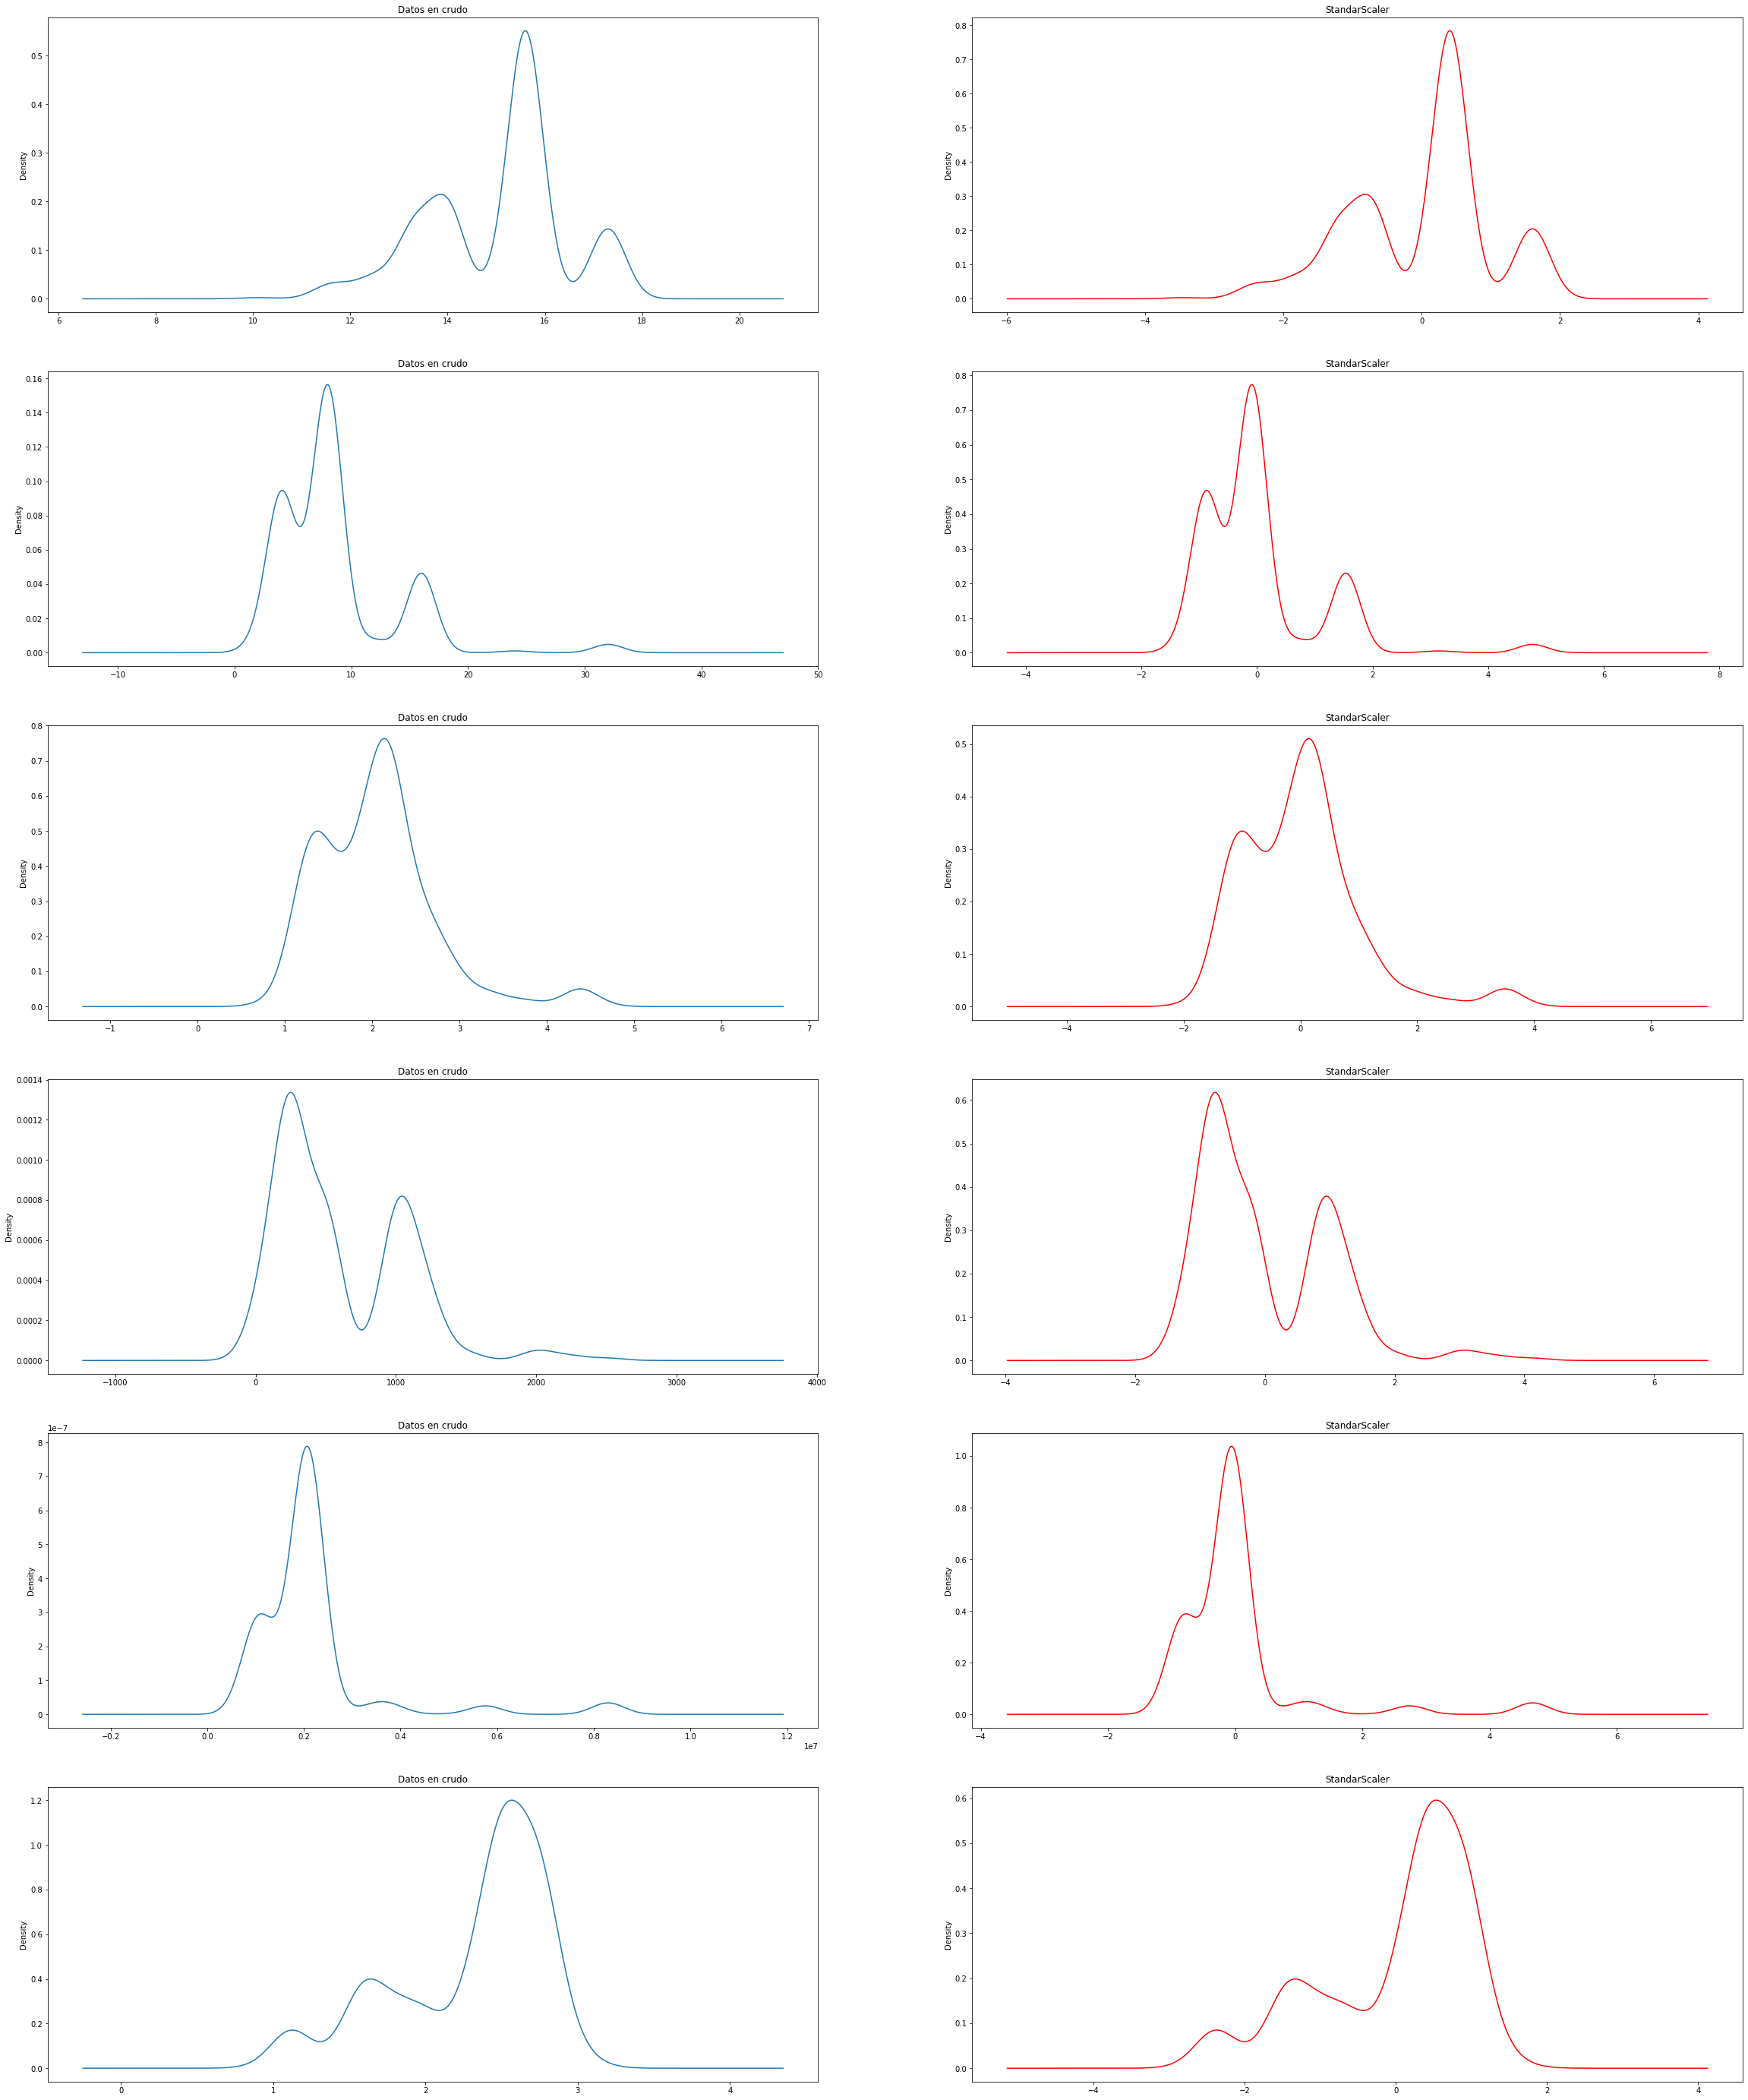

In [9]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np

data_Global = ['LaptopId', 'Weight', 'Price', 'Series', 'Company', 'IsOSFree', 'CPUBrand', 'Subseries', 'CPUModel', 'CPUSubmodel', 'CPUSpeed', 'GPUBrand', 'GPUModel', 'GPUModelNumber', 
               'GPUModelGama', 'StorageCapacity', 'HasHHD', 'HasSSD', 'HasHybrid', 'HasFlashStorage', 'ScreenPixels', 'ScreenRatio', 'IsScreenIPS', 'HasTouchscreen', 'OpSys', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu']

data_StandardScaler = ["Inches", "Ram", "Weight", "StorageCapacity", "ScreenPixels" , "CPUSpeed"]

fig, axs = plt.subplots(nrows=len(data_StandardScaler), ncols=2, figsize=(40,50))

i = 0
j = 0

for label in data_StandardScaler:

  axs[i][j].set_title('Datos en crudo')
  model.X[label].plot.kde(ax=axs[i][j])

  j += 1

  encoder_df = pd.DataFrame(StandardScaler().fit_transform(model.X[[label]]))
  df2 = model.X.join(encoder_df)
  df2.drop(data_Global, axis=1, inplace=True)

  axs[i][j].set_title('StandarScaler')

  df2.plot.kde(ax=axs[i][j], legend=False, color = 'red')

  i += 1
  j = 0






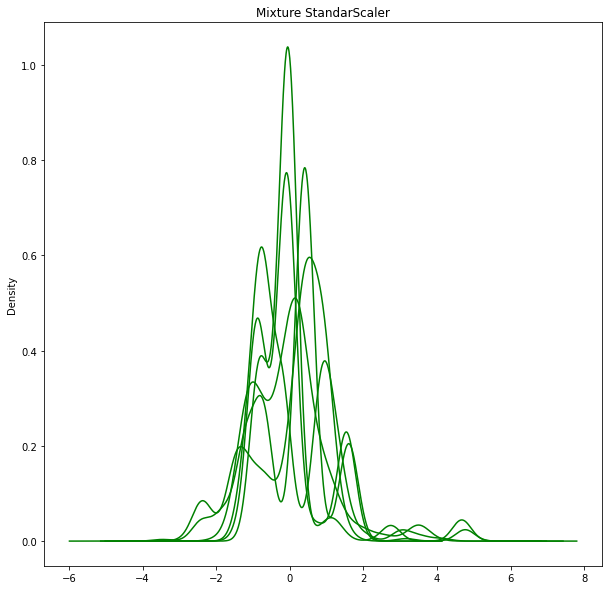

In [10]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np

data_Global = ['LaptopId', 'Weight', 'Price', 'Series', 'Company', 'IsOSFree', 'CPUBrand', 'Subseries', 'CPUModel', 'CPUSubmodel', 'CPUSpeed', 'GPUBrand', 'GPUModel', 'GPUModelNumber', 
               'GPUModelGama', 'StorageCapacity', 'HasHHD', 'HasSSD', 'HasHybrid', 'HasFlashStorage', 'ScreenPixels', 'ScreenRatio', 'IsScreenIPS', 'HasTouchscreen', 'OpSys', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu']

data_StandardScaler = ["Inches", "Ram", "Weight", "StorageCapacity", "ScreenPixels" , "CPUSpeed"]

fig1, axs1 = plt.subplots(1, 1, figsize=(10,10))

for label in data_StandardScaler:

  encoder_df = pd.DataFrame(StandardScaler().fit_transform(model.X[[label]]))
  df2 = model.X.join(encoder_df)
  df2.drop(data_Global, axis=1, inplace=True)

  axs1.set_title('Mixture StandarScaler')

  df2.plot.kde(ax=axs1, legend=False, color = 'green')

Celda para explicar transformación OneHotEncoder

In [11]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

#print (list((model.X['Company'])))
data_Global = ['LaptopId', 'Weight', 'Price', 'Series', 'Company', 'IsOSFree', 'CPUBrand', 'Subseries', 'CPUModel', 'CPUSubmodel', 'CPUSpeed', 'GPUBrand', 'GPUModel', 'GPUModelNumber', 
               'GPUModelGama', 'StorageCapacity', 'HasHHD', 'HasSSD', 'HasHybrid', 'HasFlashStorage', 'ScreenPixels', 'ScreenRatio', 'IsScreenIPS', 'HasTouchscreen', 'OpSys', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu']

data_OneHotEncoder = [ 'Company', 'CPUBrand', 'CPUModel', 'GPUBrand', 'GPUModel', 'GPUModelGama', 'ScreenRatio', "Series", 'OpSys','TypeName']

for label in data_OneHotEncoder:
  encoder_df = pd.DataFrame(OneHotEncoder().fit_transform(model.X[[label]]).toarray())
  df2 = model.X.join(encoder_df)
  display(label)
  df2.drop(data_Global, axis=1, inplace=True)
  display(df2)


'Company'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'CPUBrand'

,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
907,0.0,1.0,0.0
908,0.0,1.0,0.0
909,0.0,1.0,0.0
910,0.0,1.0,0.0


'CPUModel'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'GPUBrand'

,0,1,2,3
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
907,0.0,0.0,1.0,0.0
908,0.0,0.0,0.0,1.0
909,1.0,0.0,0.0,0.0
910,1.0,0.0,0.0,0.0


'GPUModel'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


'GPUModelGama'

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
907,0.0,0.0,0.0,1.0
908,1.0,0.0,0.0,0.0
909,0.0,1.0,0.0,0.0
910,0.0,1.0,0.0,0.0


'ScreenRatio'

,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
907,0.0,1.0,0.0
908,0.0,1.0,0.0
909,0.0,1.0,0.0
910,0.0,1.0,0.0


'Series'

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'OpSys'

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
907,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
908,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
909,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
910,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


'TypeName'

,0,1,2,3,4,5
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
907,1.0,0.0,0.0,0.0,0.0,0.0
908,0.0,1.0,0.0,0.0,0.0,0.0
909,0.0,0.0,0.0,1.0,0.0,0.0
910,0.0,0.0,0.0,1.0,0.0,0.0


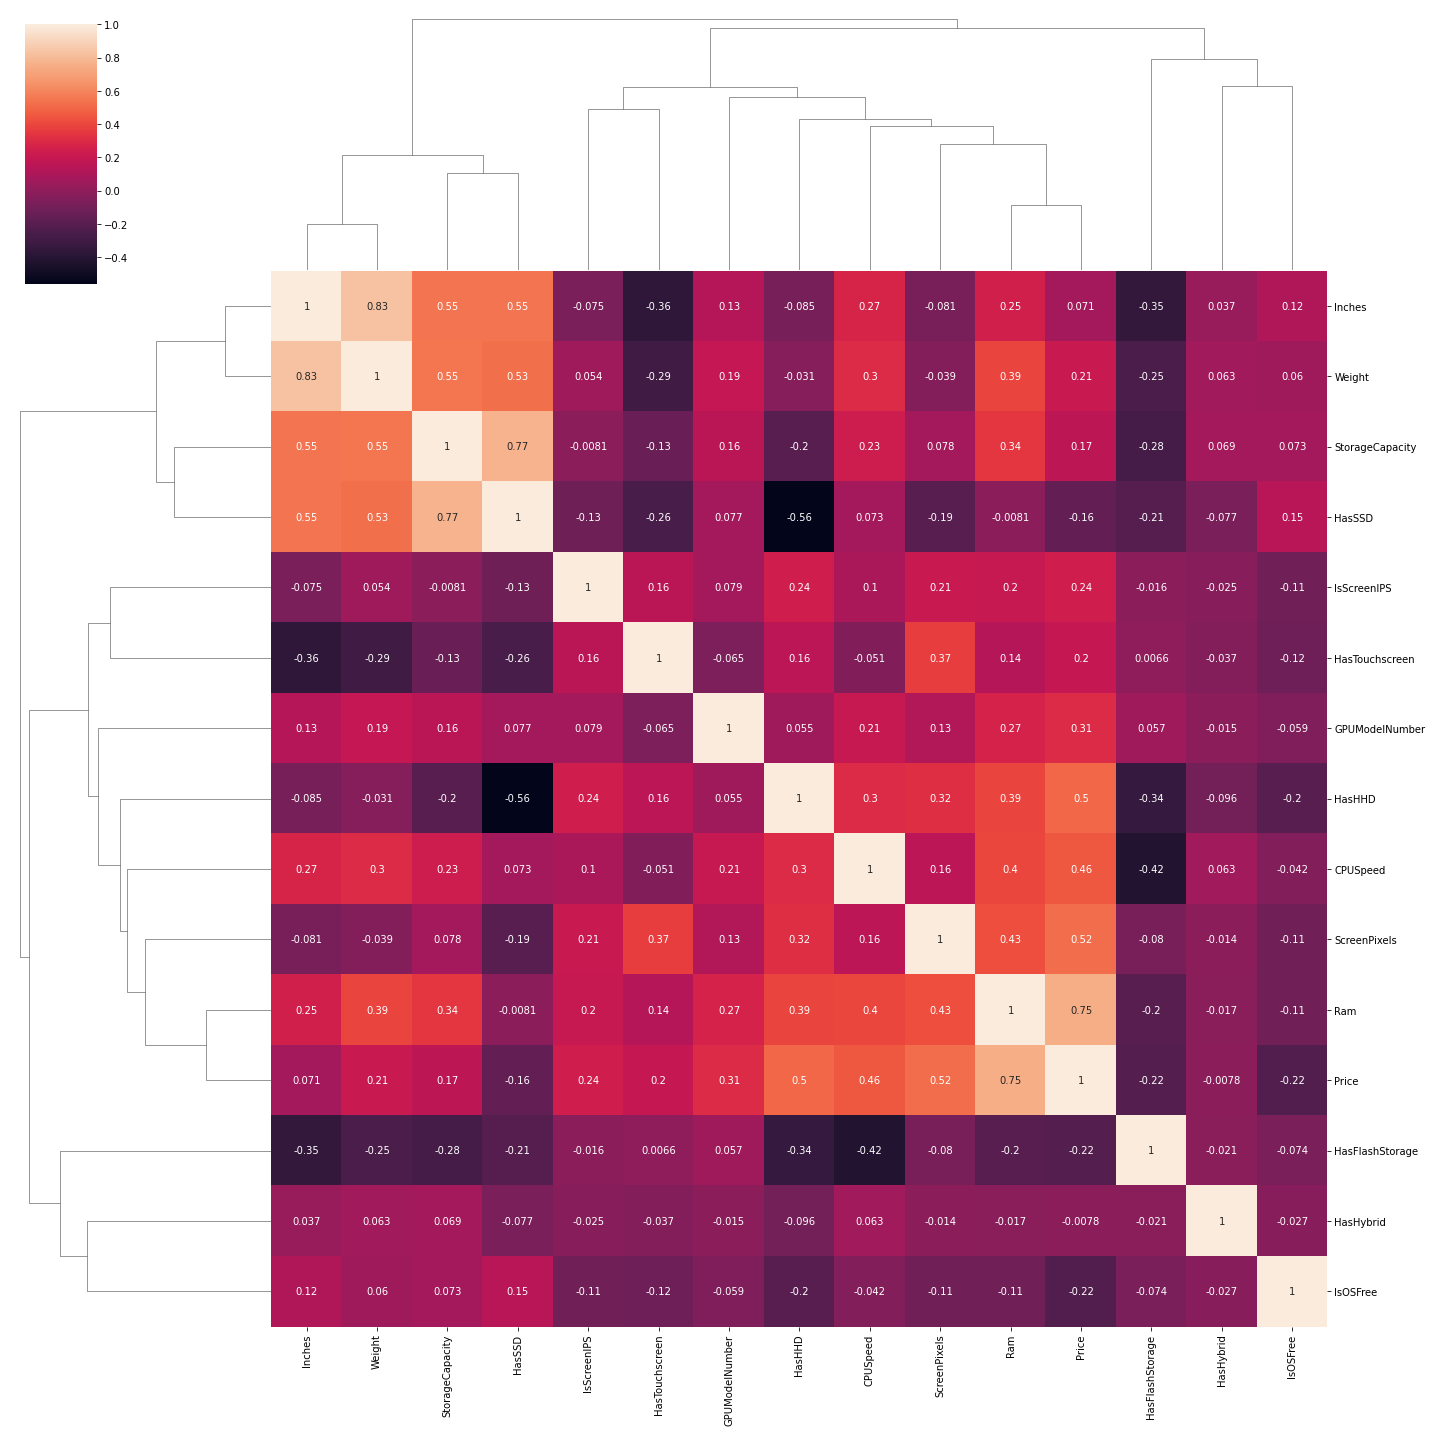

In [12]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt


data = model.X.drop(["LaptopId"], axis = 1)
sb.clustermap(data.corr(), annot=True, figsize=(20,20))

,Inches,Ram,Weight,Price,StorageCapacity,HasHHD,HasSSD,HasHybrid,HasFlashStorage,ScreenPixels,IsScreenIPS,HasTouchscreen,IsOSFree,CPUSpeed,GPUModelNumber
Inches,1.000000,0.249193,0.831367,0.070528,0.547771,-0.085408,0.547564,0.036733,-0.351271,-0.080810,-0.074680,-0.364208,0.121901,0.274186,0.133017
Ram,0.249193,1.000000,0.393121,0.754610,0.343134,0.393214,-0.008104,-0.017287,-0.198617,0.425309,0.204313,0.138298,-0.113529,0.401618,0.266187
Weight,0.831367,0.393121,1.000000,0.213469,0.550659,-0.030816,0.525570,0.062791,-0.252525,-0.038564,0.053731,-0.292588,0.059661,0.301229,0.190655
Price,0.070528,0.754610,0.213469,1.000000,0.168639,0.501391,-0.162064,-0.007828,-0.217588,0.523954,0.239815,0.197460,-0.224777,0.455947,0.305544
StorageCapacity,0.547771,0.343134,0.550659,0.168639,1.000000,-0.203427,0.772559,0.068918,-0.277038,0.078325,-0.008064,-0.133098,0.073461,0.229186,0.155146
HasHHD,-0.085408,0.393214,-0.030816,0.501391,-0.203427,1.000000,-0.558902,-0.096313,-0.336442,0.317562,0.241930,0.164810,-0.195267,0.303880,0.055435
HasSSD,0.547564,-0.008104,0.525570,-0.162064,0.772559,-0.558902,1.000000,-0.076702,-0.210046,-0.194526,-0.126064,-0.255167,0.152781,0.072951,0.076875
HasHybrid,0.036733,-0.017287,0.062791,-0.007828,0.068918,-0.096313,-0.076702,1.000000,-0.021181,-0.014382,-0.025142,-0.036977,-0.026896,0.062952,-0.014746
HasFlashStorage,-0.351271,-0.198617,-0.252525,-0.217588,-0.277038,-0.336442,-0.210046,-0.021181,1.000000,-0.080247,-0.016137,0.006593,-0.073654,-0.417460,0.056666
ScreenPixels,-0.080810,0.425309,-0.038564,0.523954,0.078325,0.317562,-0.194526,-0.014382,-0.080247,1.000000,0.211126,0.370577,-0.107629,0.160113,0.128918


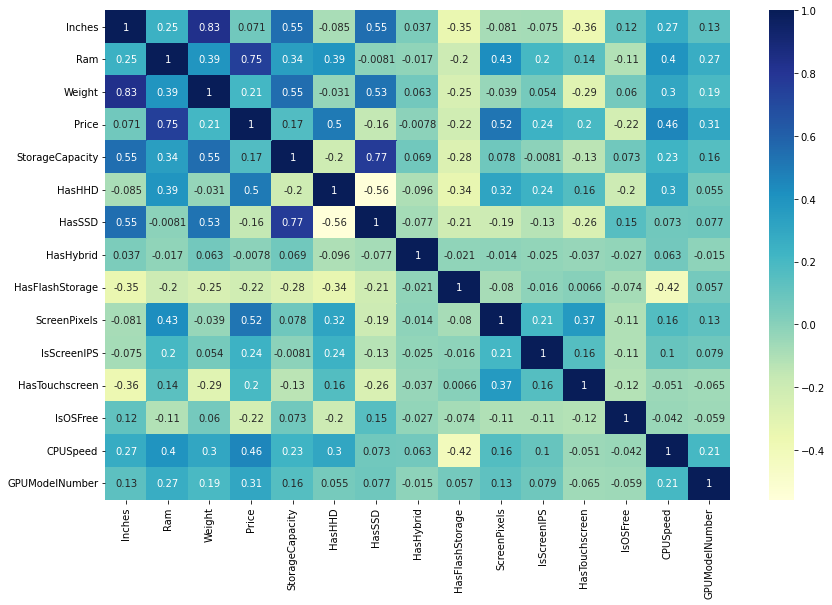

In [13]:
#Mapa de calor hay que hacerlo bien pero esta es la base
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(figsize=(14,9))
data = model.X.drop(["LaptopId"], axis = 1)

display(data.corr())

sns.heatmap(data.corr(),annot=True,cmap="YlGnBu", ax=ax)

In [17]:
#Clase Pie -> Puede que sea innecesaria y con dos metodos en draw valdría pero me hacía ilisión hacer otra clase

from traitlets.traitlets import default
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


class Pie:
  def __init__(self, label):
    self.label = label

#Solo se pueden meter nº de pie multiplos de 3 -> Si no lo es cambiar ax
  def pieN (self, labels):
    size = len(labels)
    
    f, ax = plt.subplots(int(size/3), 3,figsize=(25,25))

    i=0
    j=0
    
    colors = sns.color_palette('pastel')[0:25]

    for label in labels:
      numeros = list(set(model.X[label]))

      data = list (model.X[label])
      
      ocurrencias = {} 

      for row in numeros:
        ocurrencia = data.count(row)
        ocurrencias[row]=ocurrencia
        ocurrencia = 0

      # Creating pie
      
      ax [i][j].set_title(label)
      ax [i][j].pie(list(ocurrencias.values()),  labels = numeros, shadow=True, startangle=200, colors = colors, radius = 1.1, autopct='%.2f%%', pctdistance=.6 , textprops = {'fontsize': 9})
      #ax [i][j].legend(bbox_to_anchor=(1.05, 0.3), loc='upper left') #Añade una leyenda en funcion del color del queso

      j += 1

      if (j%3 == 0):
        i += 1 
        j = 0


  def pieB (self, labels):
      
    colors = ['#E74C3C', '#ECF0F1']
    f, ax = plt.subplots(int(len(labels)/3), 3,figsize=(25,25))

    i=0
    j=0

    for label in labels:

      numeros = [True, False]
      
      data = list (model.X[label])
      
      ocurrencias = {} 
      
      for row in numeros:
        ocurrencia = data.count(row)
        ocurrencias[row]=ocurrencia
        ocurrencia = 0

      print(ocurrencias)
      
      # Creating pie
      ax [i][j].set_title(label)    
      ax [i][j].pie(list(ocurrencias.values()), labels = numeros, shadow=True, explode = [0, 0.5], startangle=200, colors = colors, radius = 1.1, autopct='%.2f%%', pctdistance=.6 , textprops = {'fontsize': 12})
      
      j += 1

      if (j%3 == 0):
        i += 1 
        j = 0
                
        

     

{True: 78, False: 834}
{True: 137, False: 775}
{True: 603, False: 309}
{True: 394, False: 518}
{True: 50, False: 862}
{True: 246, False: 666}


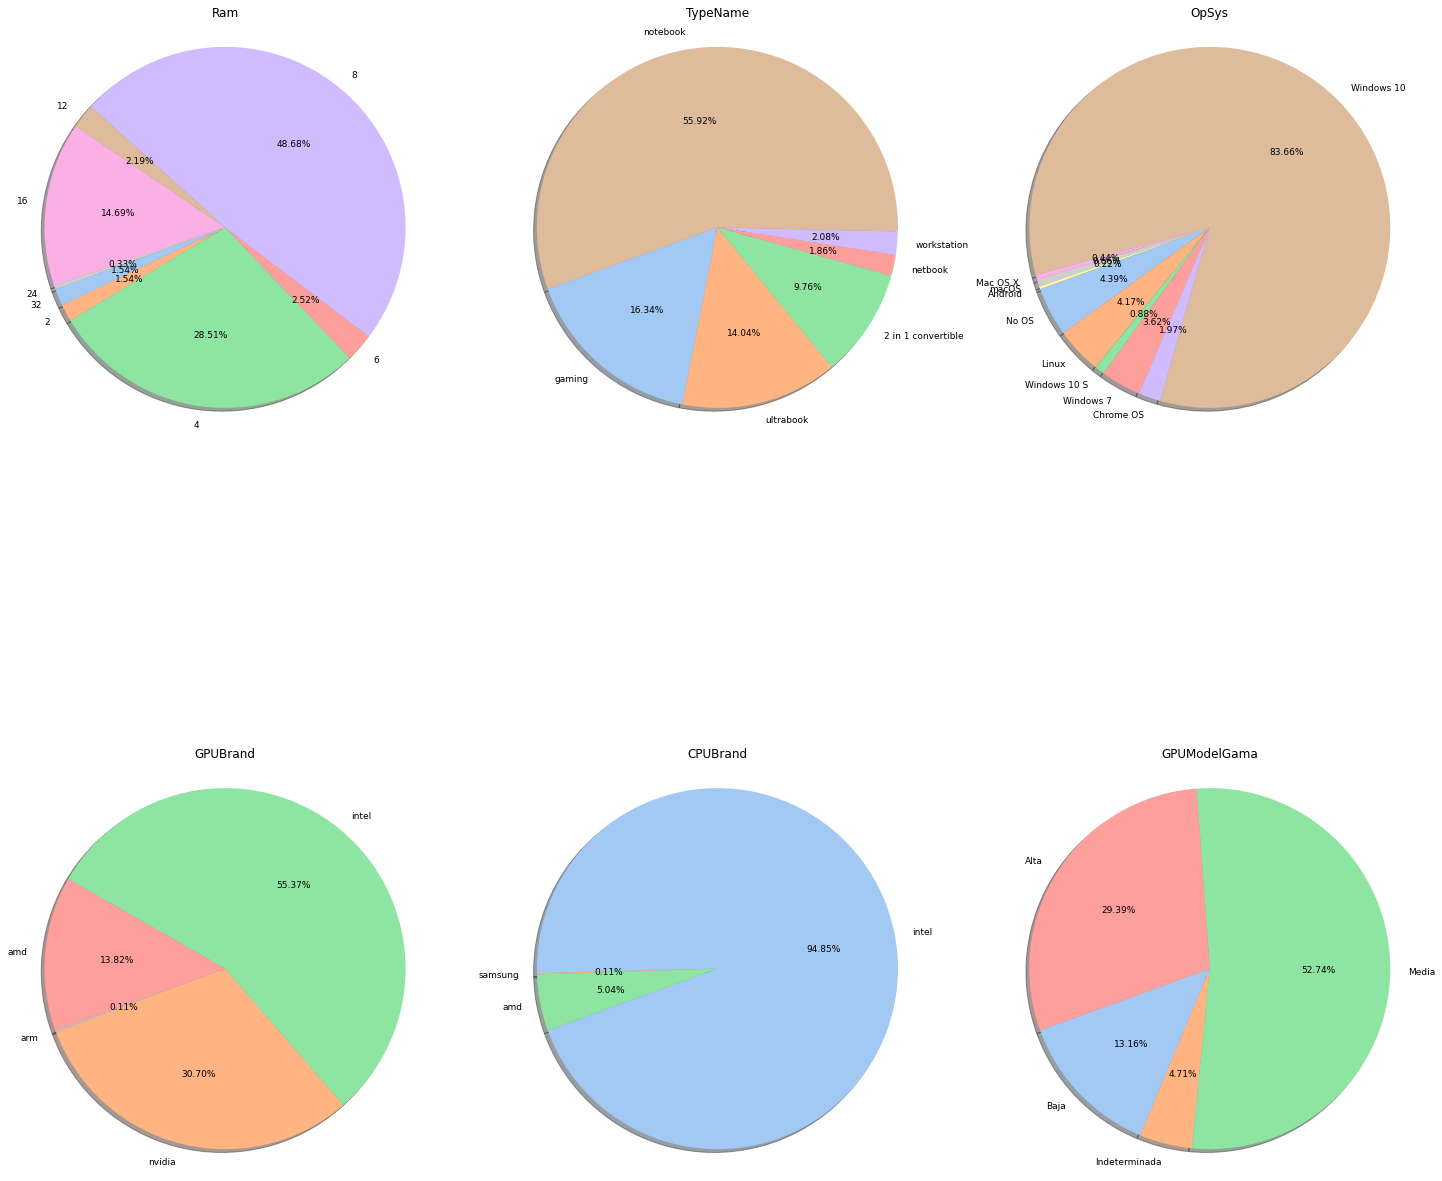

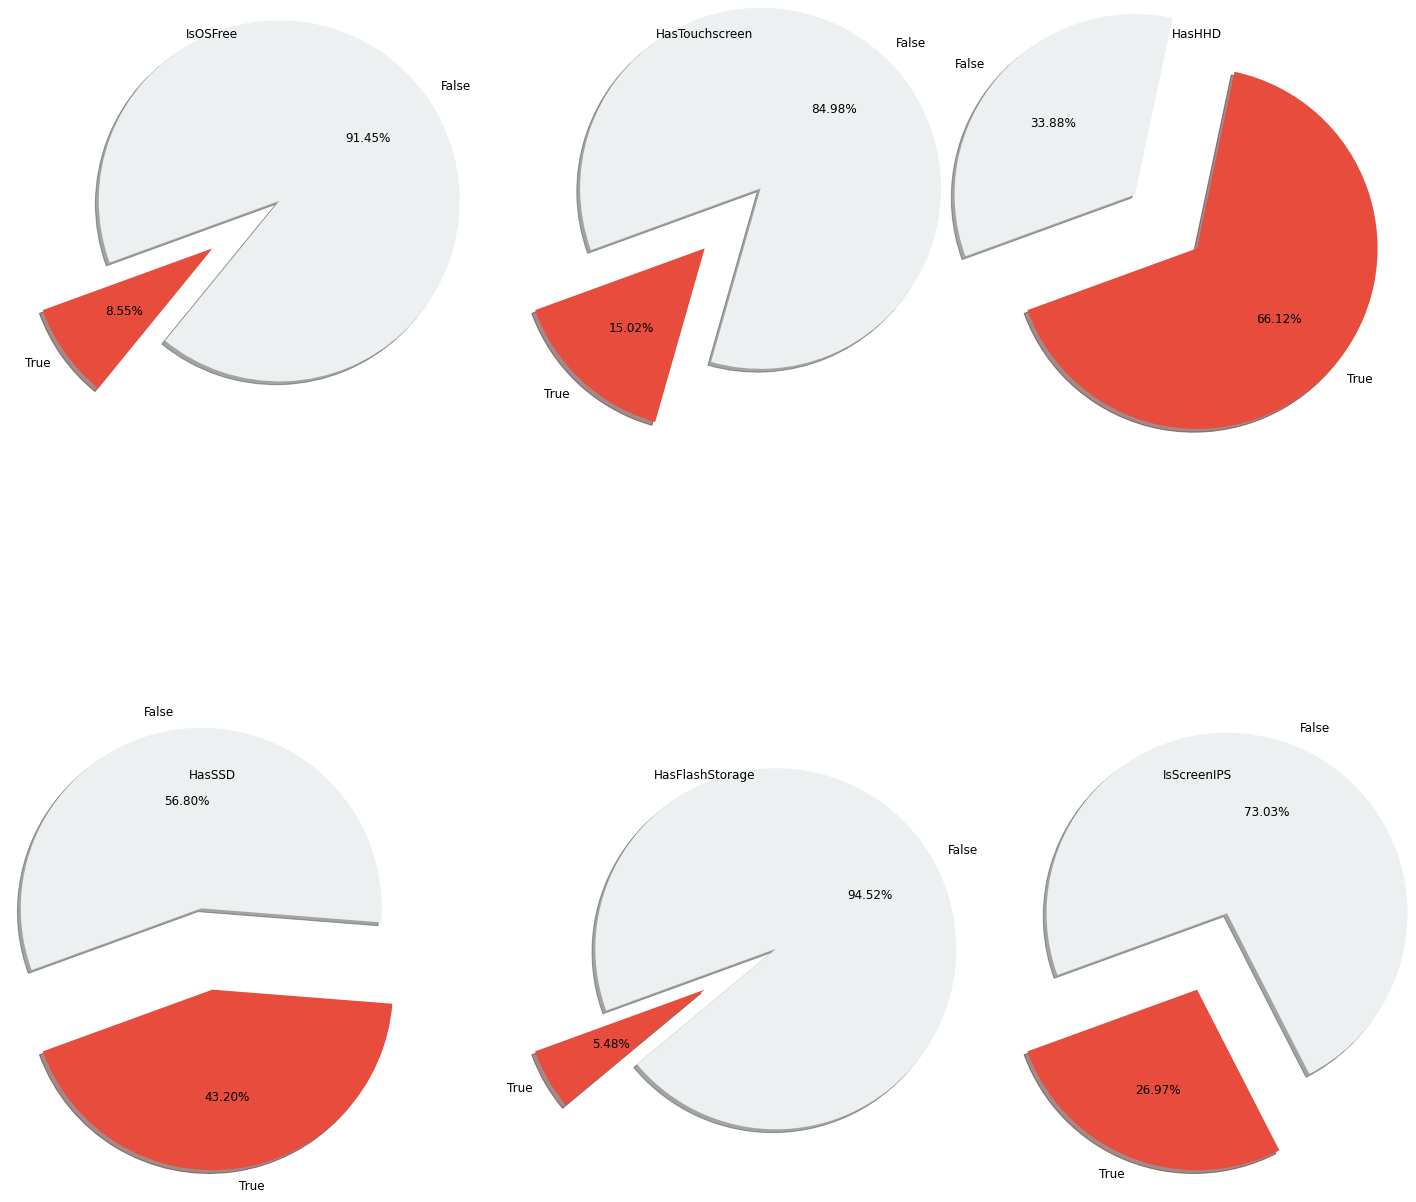

In [18]:
from traitlets.traitlets import default
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Relplot
# Scatterplot
# Density plot
# Characteristic line plot

class Draw:
  def __init__(self, model):
    self.model = model
    self.labels = [
        "Company", "Product", "TypeName", "Inches", "ScreenResolution", "Cpu", "Ram", "Memory", "Gpu", "OpSys", "Weight",
        "StorageCapacity", "HasSSD",
        "ScreenPixels", "ScreenRatio", "IsScreenIPS", "HasTouchscreen", "IsOSFree", "CPUBrand", "CPUSpeed", "GPUModel",
        "GPUModelNumber", "GPUModelGama"
    ]

  def get_grid(self, cols, rows, h, w):
      return plt.subplots(rows, cols, figsize=(w, h))

  def histogram(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.histplot(self.model.X[label], ax=axs0[i])

      aux.set_xticklabels(aux.get_xticklabels(), rotation = 80, horizontalalignment = 'right')

  #Mejorar
  def cajaBigotes(self, labels):

    data = [self.model.X["Ram"], self.model.X["Inches"], self.model.X["CPUSpeed"]] 
      
    fig = plt.figure(figsize =(10, 7)) 
    ax = fig.add_subplot(111) 
    
    bp = ax.boxplot(data, patch_artist = True, 
                    notch ='True', vert = 0) 
      
    colors = ['#E74C3C', '#3498DB', '#2ECC71'] 
      
    for patch, color in zip(bp['boxes'], colors): 
        patch.set_facecolor(color) 
      
    for whisker in bp['whiskers']: 
        whisker.set(color ='#8B008B', 
                    linewidth = 1.5, 
                    linestyle =":") 
      
    for cap in bp['caps']: 
        cap.set(color ='#8B008B', 
                linewidth = 2) 
      
    for median in bp['medians']: 
        median.set(color ='red', 
                  linewidth = 3) 
      
    for flier in bp['fliers']: 
        flier.set(marker ='D', 
                  color ='#e7298a', 
                  alpha = 2) 
          
    ax.set_yticklabels(["Ram", "Inches", "CPUSpeed"])
      
    plt.title("Datos Preprocesados") 
      
    ax.get_xaxis().tick_bottom() 
    ax.get_yaxis().tick_left() 
          
    #plt.show(bp)

  def cajaCompany(self):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_title('Diagrama de Caja y Bigotes')
    sns.boxplot(x = self.model.X['Price'], y = self.model.X['Company'], data = self.model.X )

  def cajaTypename(self):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_title('Diagrama de Caja y Bigotes')
    sns.boxplot(x = self.model.X['Price'], y = self.model.X['TypeName'], data = self.model.X )

  def countplot(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.countplot(self.model.X[label], ax=axs0[i])

      #aux0.set_xticklabels(aux0.get_xticklabels(), rotation = 85, horizontalalignment = 'right')

      aux.set(xticklabels=label)
      aux.set(xlabel=None)

  def kde(self, labels):
    # El numero de caracteristicas que tienen tipo numerico, para decidir las dimensiones
    n_of_numerical_features = len([ True for f in self.model.X if type(self.model.X[f][0]) != str ])
    
    fig, axs = self.get_grid(rows=n_of_numerical_features//4, cols=4, h=10, w=25)
    fig.delaxes(axs[1][2]) # Eliminar plots vacios
    fig.delaxes(axs[1][3])
    
    i = 0
    for label in labels:
      if type(self.model.X[label][0]) != str:
        sns.kdeplot(self.model.X[label], ax=axs[i//4, i%4])
        i += 1
  
  def relplot(self, labels, hue=None):
    rows, cols = 5, 5
    fig, axs = self.get_grid(rows=rows, cols=cols, h=20, w=30)
    #fig.delaxes(axs[2][3]) # Elimnar plots vacios

    for i, label in enumerate(labels):
      s = sns.scatterplot(data=self.model.X, x=label, y="Price", ax=axs[i//rows, i%rows], hue=hue,  cmap='rainbow')

      # Si es una feature con strings, quitar los ticks porque si no no se ve nada
      if type(self.model.X[label][0]) == str:
        s.set(xticklabels=[])  
        s.tick_params(bottom=False)

  def pieN (self, labels):        #-> Diagrama de quesitos
     model = Pie(labels)
     model.pieN(labels)
  
  def pieB (self, labels):        #-> Diagrama de quesitos
     model = Pie(labels)
     model.pieB(labels)

  def run(self):
    #self.countplot(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.histogram(["HasHHD"])
    #self.kde(self.labels)
    #self.relplot(self.labels)

    #self.cajaBigotes(self.labels)

    #Gráfica caja y bigotes con compañia y precio
    #self.cajaCompany()

    #self.cajaTypename()

    #self.cajaBigotesT(self.labels)

    dataN = ["Ram", "TypeName", "OpSys", "GPUBrand","CPUBrand", "GPUModelGama"]
    self.pieN(dataN)

    dataB = ["IsOSFree", "HasTouchscreen", "HasHHD", "HasSSD", "HasFlashStorage", "IsScreenIPS"]
    self.pieB(dataB)

    #plt.show()
  
draw = Draw(model)
draw.run()